Goal: Create a hierarchical clustering built upon both genotypic and phenotypic information. 

One proposal (40 total features): 
- 20 features for normalized abundance at T0 across native pHs
- 11 features for normalized abundance at T9 across perturbed pHs
- 9 features for structural and sequence-based information:
  - (3) Alpha helix, Beta sheet, Coil proportions
  - (2) Solvent-Accessible surface area (both total and average per residue)
  - (1) Radius of Gyration (compactness)
  - (1) Length
  - (1) Instability Index
  - (1) Isoelectric Point (pI) — pH at which the protein is net neutral




First, I need the ORFs for each of the 60 for which we have a compelete sequence after the first clustering. Then, I will use a cluster map to reduce redudancy, gather the relevant data for each one. 

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mgsa.helpers import plot

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


0 id: Soil5.scaffold_179483344_c1_1 data:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
1 id: T0.scaffold_610518454_c1_1 data:  [0.15470707 0.21599664 0.12426291 0.05912845 0.20453887 0.05995496
 0.03386055 0.00651048 0.07798389 0.04379507 0.01182144 0.0050059
 0.         0.00243378 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
2 id: T0.scaffold_914934534_c1_1 data:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
3 id: T0.scaffold_1052029150_c1_1 data:  [0.         0.         0.         0.05944473 0.13989764 0.08267372
 0.27719661 0.         0.17862588 0.0446283  0.06574255 0.0979078
 0.         0.         0.05388277 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        

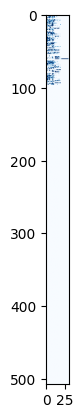

In [76]:
drug = 'None'
map = '09'
KO = 'K00370'

soils = ['Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 'Soil15', 'Soil16', 'Soil17']

cluster_ids = pd.read_csv(f'../out/orf_ids/cluster_ids_{map}_{KO}.tsv', header=None)
cluster_ids = cluster_ids.values
clustered_data = pd.read_csv(f'../out/{KO}abundances/T0data_{map}_{drug}_{KO}.tsv', sep='\t', header=None)
T0data = clustered_data.values
T0data = T0data / T0data.sum(axis=1, keepdims=True)
T0data = np.nan_to_num(T0data, nan = 0)



T9data = np.zeros((len(cluster_ids), 11))
#Add all of the T9 data arrays together to condition out native environment
for soil in soils:
    filename = f"../out/{KO}abundances/{soil}data_{map}_{drug}_{KO}.tsv"  # Construct the filename
    df = pd.read_csv(filename, sep='\t', header = None)
    df = df.values
    df = df / df.sum(axis = 1, keepdims=True)
    T9data += df 


T9data = np.nan_to_num(T9data, nan = 0)
    

data = np.hstack((T0data, T9data))
plt.imshow(data, cmap = 'Blues', vmax = 0.1)

for i in range(len(cluster_ids)):
    print(i, 'id:', cluster_ids[i][0], 'data: ', data[i])

['Soil11.scaffold_431547323_c1_2', 'Soil11.scaffold_587233302_c1_1', 'Soil11.scaffold_65427810_c1_20', 'Soil11.scaffold_211583530_c1_6', 'Soil12.scaffold_266712765_c1_2', 'Soil14.scaffold_576820813_c1_40', 'Soil14.scaffold_280216268_c1_12', 'Soil14.scaffold_465502786_c1_2', 'Soil14.scaffold_596019752_c1_119', 'Soil15.scaffold_116822102_c1_19', 'Soil15.scaffold_175810641_c1_3', 'Soil15.scaffold_16321085_c1_6', 'Soil15.scaffold_1255266399_c1_142', 'Soil16.scaffold_436666653_c1_2', 'Soil16.scaffold_804923086_c1_3', 'Soil16.scaffold_313969256_c1_10', 'Soil16.scaffold_1312607544_c1_3', 'Soil17.scaffold_1045002370_c1_23', 'Soil17.scaffold_918557319_c1_2', 'Soil17.scaffold_1202428475_c1_2', 'Soil17.scaffold_274056314_c1_61', 'Soil17.scaffold_332687915_c1_2', 'Soil3.scaffold_414071996_c1_8', 'Soil3.scaffold_333288240_c1_8', 'Soil3.scaffold_530221301_c1_2', 'Soil3.scaffold_408070428_c1_2', 'Soil3.scaffold_285743490_c1_2', 'Soil5.scaffold_133269568_c1_66', 'Soil5.scaffold_215117222_c1_59', 'Soil

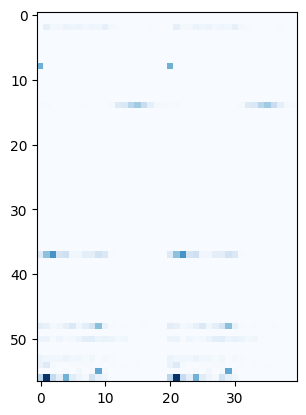

In [65]:
#load in round_1 ids which have complete sequences 

KO = 'K00370'

complete_seq_ids = pd.read_csv('../out/aaseqs/long_complete_orf_ids.txt', header = None)
complete_seq_ids = complete_seq_ids.values
complete_seq_ids = [item[0] for item in complete_seq_ids]
cluster_ids = pd.read_csv(f'../out/orf_ids/cluster_ids_{map}_{KO}.tsv', header=None)
cluster_ids = cluster_ids.values
cluster_ids = [item[0] for item in cluster_ids]
print(complete_seq_ids)
print(cluster_ids)
print(len(complete_seq_ids))
print(len(cluster_ids))


indices = [cluster_ids.index(item) for item in complete_seq_ids if item in cluster_ids]

data_subset = []

for idx in indices:
    data_subset.append(data[idx])
    
data_subset = [item.tolist() for item in data_subset]

print(data_subset)
plt.imshow(data_subset, cmap = 'Blues')

In [48]:
from Bio.PDB import PDBParser, PPBuilder
from collections import defaultdict
import math

def classify_secondary_structure(phi, psi):
    """Classify residue as helix, sheet, or coil based on dihedral angles"""
    if phi is None or psi is None:
        return 'coil'
    
    phi_deg = math.degrees(phi)
    psi_deg = math.degrees(psi)
    
    # Alpha-helix range (-57,-47)
    if (-90 < phi_deg < -30) and (-77 < psi_deg < -17):
        return 'helix'
    # Beta-sheet range (-119,113)
    elif (-180 < phi_deg < -40) and (90 < psi_deg < 180) or (-180 < phi_deg < -40) and (-180 < psi_deg < -100):
        return 'sheet'
    else:
        return 'coil'

def get_secondary_structure_proportions(pdb_file):
    """Calculate secondary structure proportions using dihedral angles"""
    parser = PDBParser()
    structure = parser.get_structure("protein", pdb_file)
    ppb = PPBuilder()
    
    secondary_structure = defaultdict(int)
    total_residues = 0
    
    for pp in ppb.build_peptides(structure):
        # Get phi/psi angles for each residue
        angles = pp.get_phi_psi_list()
        for i, residue in enumerate(pp):
            total_residues += 1
            phi, psi = angles[i]
            ss_type = classify_secondary_structure(phi, psi)
            secondary_structure[ss_type] += 1
    
    if total_residues > 0:
        return {
            'helix': secondary_structure['helix'] / total_residues,
            'sheet': secondary_structure['sheet'] / total_residues,
            'coil': secondary_structure['coil'] / total_residues
        }
    return {'helix': 0, 'sheet': 0, 'coil': 0}


pdb_file = '../out/structure/nar/Soil9.scaffold_209032411_c1_3.pdb'
proportions = get_secondary_structure_proportions(pdb_file)
print(f"Helix: {proportions['helix']:.2%}")
print(f"Sheet: {proportions['sheet']:.2%}")
print(f"Coil: {proportions['coil']:.2%}")

coil_data = []

for id in complete_seq_ids:
    pdb_file = f'../out/structure/nar/{id}.pdb'
    proportions = get_secondary_structure_proportions(pdb_file)
    coil_data.append([id, proportions['helix'], proportions['sheet'], proportions['coil']])
    print([id, proportions['helix'], proportions['sheet'], proportions['coil']])
    


Helix: 35.46%
Sheet: 41.61%
Coil: 22.93%
['Soil11.scaffold_431547323_c1_2', 0.3541147132169576, 0.42144638403990026, 0.22443890274314215]
['Soil11.scaffold_587233302_c1_1', 0.3497975708502024, 0.4145748987854251, 0.23562753036437248]
['Soil11.scaffold_65427810_c1_20', 0.35390946502057613, 0.41069958847736626, 0.2353909465020576]
['Soil11.scaffold_211583530_c1_6', 0.3383280757097792, 0.4187697160883281, 0.24290220820189273]
['Soil12.scaffold_266712765_c1_2', 0.337087691069992, 0.40627514078841515, 0.25663716814159293]
['Soil14.scaffold_576820813_c1_40', 0.35571542765787373, 0.40687450039968026, 0.23741007194244604]
['Soil14.scaffold_280216268_c1_12', 0.3431528662420382, 0.4052547770700637, 0.2515923566878981]
['Soil14.scaffold_465502786_c1_2', 0.35218093699515346, 0.41033925686591277, 0.23747980613893377]
['Soil14.scaffold_596019752_c1_119', 0.3471882640586797, 0.4172779136104319, 0.23553382233088835]
['Soil15.scaffold_116822102_c1_19', 0.33990536277602523, 0.41719242902208203, 0.242902

In [58]:

column = [row[2] for row in coil_data]
print(np.mean(column))
print(np.std(column))


0.41462075579218993
0.005389658967763842
